In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, WhiteKernel, ConstantKernel
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from matplotlib.font_manager import FontProperties
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from scipy.optimize import differential_evolution
from scipy.spatial.distance import cdist
import joblib
from Processing import cdata

In [41]:
# Load data and models
data = pd.read_excel("PFAS soil Database.xlsx", nrows=52)
data = data[['Init. Pulse Voltage', 'PFAS Content', 'F ion Content']]
new_data = cdata.copy()
new_data = new_data.reset_index(drop=True)
n_data = pd.concat([new_data, data.reset_index(drop=True)], axis=1)
n_data = n_data[n_data['PFAS Content'] != 0.019]
data1 = pd.read_excel("PFAS soil Database.xlsx", nrows=61)
updata = data1.loc[58:61, ['Material Name', 'Weight_ratio', 'Initial total mass', 'Init. Res.(Ω)', 'Init. Pulse Voltage', 'PFAS Content', 'F ion Content']]
n_data = pd.concat([n_data, updata], ignore_index=True)
gp_P = joblib.load("gp_P.joblib")
xgboost_model = joblib.load("xgb_constraint_model.joblib")

In [42]:
def visualize_sampling(encoded_existing_data, new_samples, gp_P):
    gp_model = gp_P['model']
    # Encode newly generated points
    encoded_new_samples = []
    for sample in new_samples:
        df_sample = pd.DataFrame([sample['sample']])  # Convert to DataFrame format
        encoded_sample = gp_model.named_steps['preprocessor'].transform(df_sample)
        encoded_new_samples.append(encoded_sample)
    encoded_new_samples = np.vstack(encoded_new_samples)

    # Use PCA to reduce data to 2D
    pca = PCA(n_components=2)
    combined_data = np.vstack([encoded_existing_data, encoded_new_samples])
    reduced_data = pca.fit_transform(combined_data)

    # Separate existing data from newly generated points
    reduced_existing = reduced_data[:len(encoded_existing_data)]
    reduced_generated = reduced_data[len(encoded_existing_data):]

    fig=plt.figure(figsize=(10, 10), dpi=600)
    # Plot existing data points
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.scatter(reduced_existing[:, 0], reduced_existing[:, 1], label='Existing Data', c='black', s=400)
    
    # Use different markers for each candidate point
    markers = ['p', '^', 's', 'd', 'x', '+', 'v', '<', '>', 'p']
    #colors = ['#9370DB', '#FF7F50', '#32CD32', '#FF4500', '#1E90FF']  # Different colors
    
    for i, point in enumerate(reduced_generated):
        marker_idx = i % len(markers)
        #color_idx = i % len(colors)
        plt.scatter(point[0], point[1], marker=markers[marker_idx], s=600, 
                    #color=colors[color_idx], 
                    label=f'Candidate Point {i+1}', color = '#8CB2DE', edgecolors='black', linewidths=4)
    
    plt.xlabel('PC1', fontsize=35, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('PC2', fontsize=35, fontweight='bold', fontname='Times New Roman')
    plt.tick_params(axis='both', which='major', labelsize=33, length = 10, width = 3, direction='in')
    
    ax = plt.gca()
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    plt.xticks(np.arange(int(x_min), int(x_max)+1, 1))
    plt.yticks(np.arange(int(y_min), int(y_max)+1, 1))
    
    times_bold = FontProperties(family='Times New Roman', weight='bold', size=28)
    ax.legend(frameon=False, prop=times_bold, loc="upper left", labelspacing=1)
    
    for spine in ax.spines.values():
        spine.set_linewidth(4)

    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    fig.set_size_inches(10, 10)
    plt.show()

In [43]:
categorical_features = {
    "Material Name": ["c-Soil(PFOA):biochar", "c-Soil(PFOA):metcoke", "c-Soil(PFOA):carbon black"],
    "Weight_ratio": ["ratio of 1:1", "ratio of 2:1", "ratio of 3:1", "ratio of 4:1"]
}
numerical_bounds = {
    "Initial total mass": (290, 350),
    "Init. Res.(Ω)": (0.8, 19.9),
    "Init. Pulse Voltage": (40, 150)
}

onehot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

existing_data = n_data.drop(columns=['PFAS Content', 'F ion Content'])

def preprocess_existing_data(existing_data):
    # Encode categorical features
    encoded_categorical = onehot_encoder.fit_transform(existing_data[["Material Name", "Weight_ratio"]])
    # Standardize numerical features
    numerical_data = existing_data[["Initial total mass", "Init. Res.(Ω)", "Init. Pulse Voltage"]]
    scaled_numerical = scaler.fit_transform(numerical_data)
    # Combine encoded features
    return np.hstack([encoded_categorical, scaled_numerical])

encoded_existing_data = preprocess_existing_data(existing_data)

In [44]:
def acquisition_function(X, gp_P, existing_data, alpha, gamma, P):

    model = gp_P['model']
    # Get predictions and standard deviations
    mu_P, sigma_P = model.predict(X, return_std=True)

    acquisition_P = mu_P - alpha * sigma_P *P

    return acquisition_P

def predict_init_res(material_name, weight_ratio, initial_mass):
    """
    Use xgboost model to predict Init. Res.(Ω), ensuring scalar value return.
    """
    sample_features = pd.DataFrame([{
        "Material Name": material_name,
        "Weight_ratio": weight_ratio,
        "Initial total mass": initial_mass
    }])

    return float(xgboost_model.predict(sample_features)[0])

In [45]:
def incremental(gp, existing_data, new_sample):

    pipeline_model = gp['model']
    preprocessor = pipeline_model.named_steps['preprocessor']
    gp_model = pipeline_model.named_steps['gp']
    
    X_new = new_sample[['Material Name', 'Weight_ratio', 'Initial total mass', 'Init. Res.(Ω)', 'Init. Pulse Voltage']]
    X_new_transformed = preprocessor.transform(X_new)
    y_pred_log = gp_model.predict(X_new_transformed)

    new_sample['Log_PFAS_Content'] = y_pred_log
    new_sample['PFAS Content'] = np.exp(y_pred_log)

    # Merge data
    updated_data = pd.concat([existing_data, new_sample], ignore_index=True)
    updated_data['Log_PFAS_Content'] = np.log(updated_data['PFAS Content'])
    
    # Extract merged features and target values
    X = updated_data[['Material Name', 'Weight_ratio', 'Initial total mass', 'Init. Res.(Ω)', 'Init. Pulse Voltage']]
    y = updated_data['Log_PFAS_Content']

    # Preprocess data
    X_transformed = preprocessor.fit_transform(X)
    gp_model.fit(X_transformed, y)

    return updated_data

In [ ]:
def optimize_acquisition(gp_P, existing_data, alpha, gamma, P):
    bounds = [
        (0, len(categorical_features["Material Name"]) - 1),
        (0, len(categorical_features["Weight_ratio"]) - 1),
        numerical_bounds["Initial total mass"],
        numerical_bounds["Init. Res.(Ω)"],
        numerical_bounds["Init. Pulse Voltage"]
    ]

    def func(x):
        material_idx = int(round(x[0]))
        weight_idx = int(round(x[1]))
        Int_resistance = round(x[3], 2)
        total_mass = int(round(x[2]))
        init_pulse_voltage = int(round(x[4]))

        material_name = categorical_features["Material Name"][material_idx]
        weight_ratio = categorical_features["Weight_ratio"][weight_idx]

        predicted_res = predict_init_res(material_name, weight_ratio, total_mass)

        if abs(predicted_res - Int_resistance)/predicted_res > 0.3:
            return 1e10  # Penalty value
        
        # Construct sampling point
        sample = pd.DataFrame([{
            "Material Name": material_name,
            "Weight_ratio": weight_ratio,
            "Initial total mass": total_mass,
            "Init. Res.(Ω)": Int_resistance,
            "Init. Pulse Voltage": init_pulse_voltage
        }])

        # Call acquisition function and ensure scalar return
        result = acquisition_function(sample, gp_P, existing_data, alpha=alpha, gamma=gamma, P=1)
        #print(f"Acquisition function result: {result}, type: {type(result)}")  # Debug information
        result = float(result)
        import warnings
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        
        return result

    try:
        result = differential_evolution(func, bounds=bounds)
    except Exception as e:
        print("Error during optimization:", e)
        raise

    best_x = result.x
    best_x[2] = int(round(best_x[2]))
    best_x[3] = round(best_x[3], 2)
    best_x[4] = int(round(best_x[4]))
    best_acquisition = result.fun

    best_sample = {
        "Material Name": categorical_features["Material Name"][int(round(best_x[0]))],
        "Weight_ratio": categorical_features["Weight_ratio"][int(round(best_x[1]))],
        "Initial total mass": best_x[2],
        "Init. Res.(Ω)": best_x[3],
        "Init. Pulse Voltage": best_x[4]
    }
    return best_sample, best_acquisition


# Bayesian optimization main loop
def recommend_next_expriment(gp_P, existing_data, alpha=0.05, gamma=1, batch_size=1, P0=1):
    
    def visualize_gp_heatmap(gp_model, batch_samples, existing_data, grid_size=50, save_path=None):
        """
        Visualize GP model's mean and standard deviation heatmaps and save them separately.
        
        Parameters:
        - gp_model: GP model
        - batch_samples: List of recommended points
        - existing_data: Existing data
        - grid_size: Grid size
        - save_path: Save path prefix, if provided, will save as '[save_path]_mean.png' and '[save_path]_std.png'
        
        Returns:
        - fig_mean, fig_std: Two figure objects
        """
        import matplotlib.pyplot as plt
        from sklearn.decomposition import PCA
        import numpy as np
        
        # Get feature names
        features = ['Material Name', 'Weight_ratio', 'Initial total mass', 'Init. Res.(Ω)', 'Init. Pulse Voltage']
        
        # Extract existing data and recommended points
        X_existing = existing_data[features]
        
        # Extract recommended points
        X_recommended = pd.DataFrame([sample['sample'] for sample in batch_samples])
        
        # Combine data for PCA dimensionality reduction
        X_combined = pd.concat([X_existing, X_recommended], ignore_index=True)
        
        gp_model = gp_P['model']
        # Create column transformer
        preprocessor = gp_model.named_steps['preprocessor']
        
        # Transform all data
        X_transformed = preprocessor.transform(X_combined)
        
        # Apply PCA dimensionality reduction to 2D
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X_transformed)
        
        # Separate existing data and recommended points
        existing_2d = X_2d[:len(X_existing)]
        recommended_2d = X_2d[len(X_existing):]
        
        # Create grid for heatmap
        x_min, x_max = X_2d[:, 0].min() -0.5, X_2d[:, 0].max() +0.5
        y_min, y_max = X_2d[:, 1].min() -0.5, X_2d[:, 1].max() +0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                             np.linspace(y_min, y_max, grid_size))
        
        # Create PCA inverse transform for each grid point back to original space
        grid_2d = np.c_[xx.ravel(), yy.ravel()]
        
        # Use nearest neighbor method
        from sklearn.neighbors import NearestNeighbors
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(X_2d)
        grid_indices = nn.kneighbors(grid_2d, return_distance=False).ravel()
        
        # Get corresponding original space points
        grid_original = X_transformed[grid_indices]
        
        # Calculate GP predictions
        mu, sigma = gp_model.named_steps['gp'].predict(grid_original, return_std=True)
        
        # Reshape to grid shape
        mu_grid = mu.reshape(xx.shape)
        sigma_grid = sigma.reshape(xx.shape)
        
        # Define different markers and colors for different recommended points
        markers = ['p', '^', 's', 'd', 'x', '+', 'v', '<', '>', 'p']
        #colors = ['#9370DB', '#FF7F50', '#32CD32', '#FF4500', '#1E90FF'] 
        
        # Create mean plot
        fig_mean = plt.figure(figsize=(12, 10), dpi=600)
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['savefig.dpi'] = 600
        ax1 = fig_mean.add_subplot(111)
        
        
        im1 = ax1.contourf(xx, yy, mu_grid, cmap='Spectral', alpha=0.8, levels=100)
        
        # Use different markers for each recommended point
        for i, point in enumerate(recommended_2d):
            marker_idx = i % len(markers)
            #color_idx = i % len(colors)
            ax1.scatter(point[0], point[1], c='#8CB2DE', s=1000, 
                        marker=markers[marker_idx], edgecolors='black', linewidths=4
                       #label=f'Candidate Point {i+1}'
                       )
        
        ax1.set_xlabel('dim 1', fontsize=35, fontweight='bold', fontname='Times New Roman')
        ax1.set_ylabel('dim 2', fontsize=35, fontweight='bold', fontname='Times New Roman')
        ax1.tick_params(axis='both', which='major', labelsize=30, length=10, width=3, direction='in')
        ax1.legend(fontsize=25, frameon=False)
        
        # Add colorbar and set style
        cbar1 = fig_mean.colorbar(im1, ax=ax1)
        cbar1.ax.tick_params(labelsize=30, width=3)
        cbar1.set_label('GP Mean', fontsize=30, fontweight='bold')

        for label in cbar1.ax.get_yticklabels():
            label.set_fontweight('bold')
            label.set_fontname('Times New Roman')

        for spine in ax1.spines.values():
            spine.set_linewidth(4)
        
        for label in ax1.get_xticklabels():
            label.set_fontweight('bold')
        
        for label in ax1.get_yticklabels():
            label.set_fontweight('bold')
        
        x_min, x_max = ax1.get_xlim()
        y_min, y_max = ax1.get_ylim()
        ax1.set_xticks(np.arange(int(x_min), int(x_max)+1, 1))
        ax1.set_yticks(np.arange(int(y_min), int(y_max)+1, 1))
        fig_mean.set_size_inches(12, 10)
        plt.show()
        plt.tight_layout()
        plt.savefig('heatmap_mean.png', dpi=600, bbox_inches='tight')
        # If save path is provided, save mean plot
        if save_path:
            mean_path = f"{save_path}_mean.png"
            fig_mean.savefig(mean_path, dpi=300, bbox_inches='tight')
            print(f"Mean heatmap saved to {mean_path}")
        
        # Create standard deviation plot
        fig_std = plt.figure(figsize=(12, 10), dpi=600)
        plt.rcParams['savefig.dpi'] = 600
        ax2 = fig_std.add_subplot(111)
        
        im2 = ax2.contourf(xx, yy, sigma_grid, cmap='Spectral', alpha=0.8, levels=100)
        
        # Use different markers for each recommended point (same markers as mean plot)
        for i, point in enumerate(recommended_2d):
            marker_idx = i % len(markers)
            #color_idx = i % len(colors)
            ax2.scatter(point[0], point[1], c='#8CB2DE', s=1000, marker=markers[marker_idx], edgecolors='black',
                       linewidths=4, #label=f'Candidate Point {i+1}'
                       )
        
        ax2.set_xlabel('dim 1', fontsize=35, fontweight='bold', fontname='Times New Roman')
        ax2.set_ylabel('dim 2', fontsize=35, fontweight='bold', fontname='Times New Roman')
        ax2.tick_params(axis='both', which='major', labelsize=30, length=10, width=3, direction='in')
        ax2.legend(fontsize=25, frameon=False)
        
        # Add colorbar and set style
        cbar2 = fig_std.colorbar(im2, ax=ax2)
        cbar2.ax.tick_params(labelsize=30, width =3)
        cbar2.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
        cbar2.set_label('Uncertainty', fontsize=30, fontweight='bold')

        
        # If save path is provided, save standard deviation plot
        if save_path:
            std_path = f"{save_path}_std.png"
            fig_std.savefig(std_path, dpi=300, bbox_inches='tight')
            print(f"Standard deviation heatmap saved to {std_path}")
        for label in cbar2.ax.get_yticklabels():
            label.set_fontweight('bold')
            label.set_fontname('Times New Roman')
        for spine in ax2.spines.values():
            spine.set_linewidth(4)
        for label in ax2.get_xticklabels():
            label.set_fontweight('bold')
        
        for label in ax2.get_yticklabels():
            label.set_fontweight('bold')
        x_min, x_max = ax2.get_xlim()
        y_min, y_max = ax2.get_ylim()
        ax2.set_xticks(np.arange(int(x_min), int(x_max)+1, 1))
        ax2.set_yticks(np.arange(int(y_min), int(y_max)+1, 1))
        
        fig_std.set_size_inches(12, 10)
        plt.show()
        plt.tight_layout()
        plt.savefig('heatmap_uncertainty.png', dpi=600, bbox_inches='tight')
        return fig_mean, fig_std
 
    existing_data = n_data
    all_samples = []
    best_overall = {"sample": None, "acquisition": np.inf}

    P = P0
    
    # Generate specified number of recommended points
    for i in range(batch_size):
        print(f"\nGenerating the {i+1}/{batch_size}th sample:")
        best_sample, acquisition_value = optimize_acquisition(gp_P, existing_data, alpha, gamma, P)
        
        # Print current recommended point information
        print(f"Recommend #{i+1}:")
        for key, value in best_sample.items():
            print(f"  {key}: {value}")
        print(f"Acquisition Value: {acquisition_value}")

        user_score_str = input(f"Please provide a score for the {i+1}/{batch_size}th sample (0-3, 0=very bad, 3=very good): ")
        user_score = float(user_score_str)

        while user_score < 0 or user_score > 3:
            print("Score must be between 0 and 3")
            user_score_str = input(f"Please provide a score for the {i+1}/{batch_size}th sample (0-3, 0=very bad, 3=very good): ")
            user_score = float(user_score_str)

        scale = 6
        center = 1.5
        normalized_scores = scale * (user_score - center)
        P = 1 / (1 + np.exp(-normalized_scores))
        P = P*P

        new_S_U = pd.DataFrame([best_sample])
        if acquisition_value < best_overall["acquisition"]:
            best_overall = {"sample": best_sample, "acquisition": acquisition_value}

        existing_data = incremental(gp_P, existing_data, new_S_U)
        
        all_samples.append({'sample': best_sample, 'acquisition': acquisition_value})

        # Show visualization immediately after generating each recommended point
        print(f"\n=== Visualizations for Recommend #{i+1} ===")
        visualize_sampling(encoded_existing_data, all_samples, gp_P)
        visualize_gp_heatmap(gp_P, all_samples, n_data, grid_size=50, save_path=f"heatmap_{i+1}")

        if user_score == 0:
            print("\nscore is 0, batch processing terminated.")
            break
    
    # Return different results based on batch_size
    if batch_size == 1:
        return all_samples[0]['sample'], all_samples[0]['acquisition']
    else:
        return all_samples, best_overall


Generating the 1/10th sample:
Recommend #1:
  Material Name: c-Soil(PFOA):biochar
  Weight_ratio: ratio of 1:1
  Initial total mass: 299.0
  Init. Res.(Ω): 1.99
  Init. Pulse Voltage: 150.0
Acquisition Value: -3.205842186991077

=== Visualizations for Recommend #1 ===


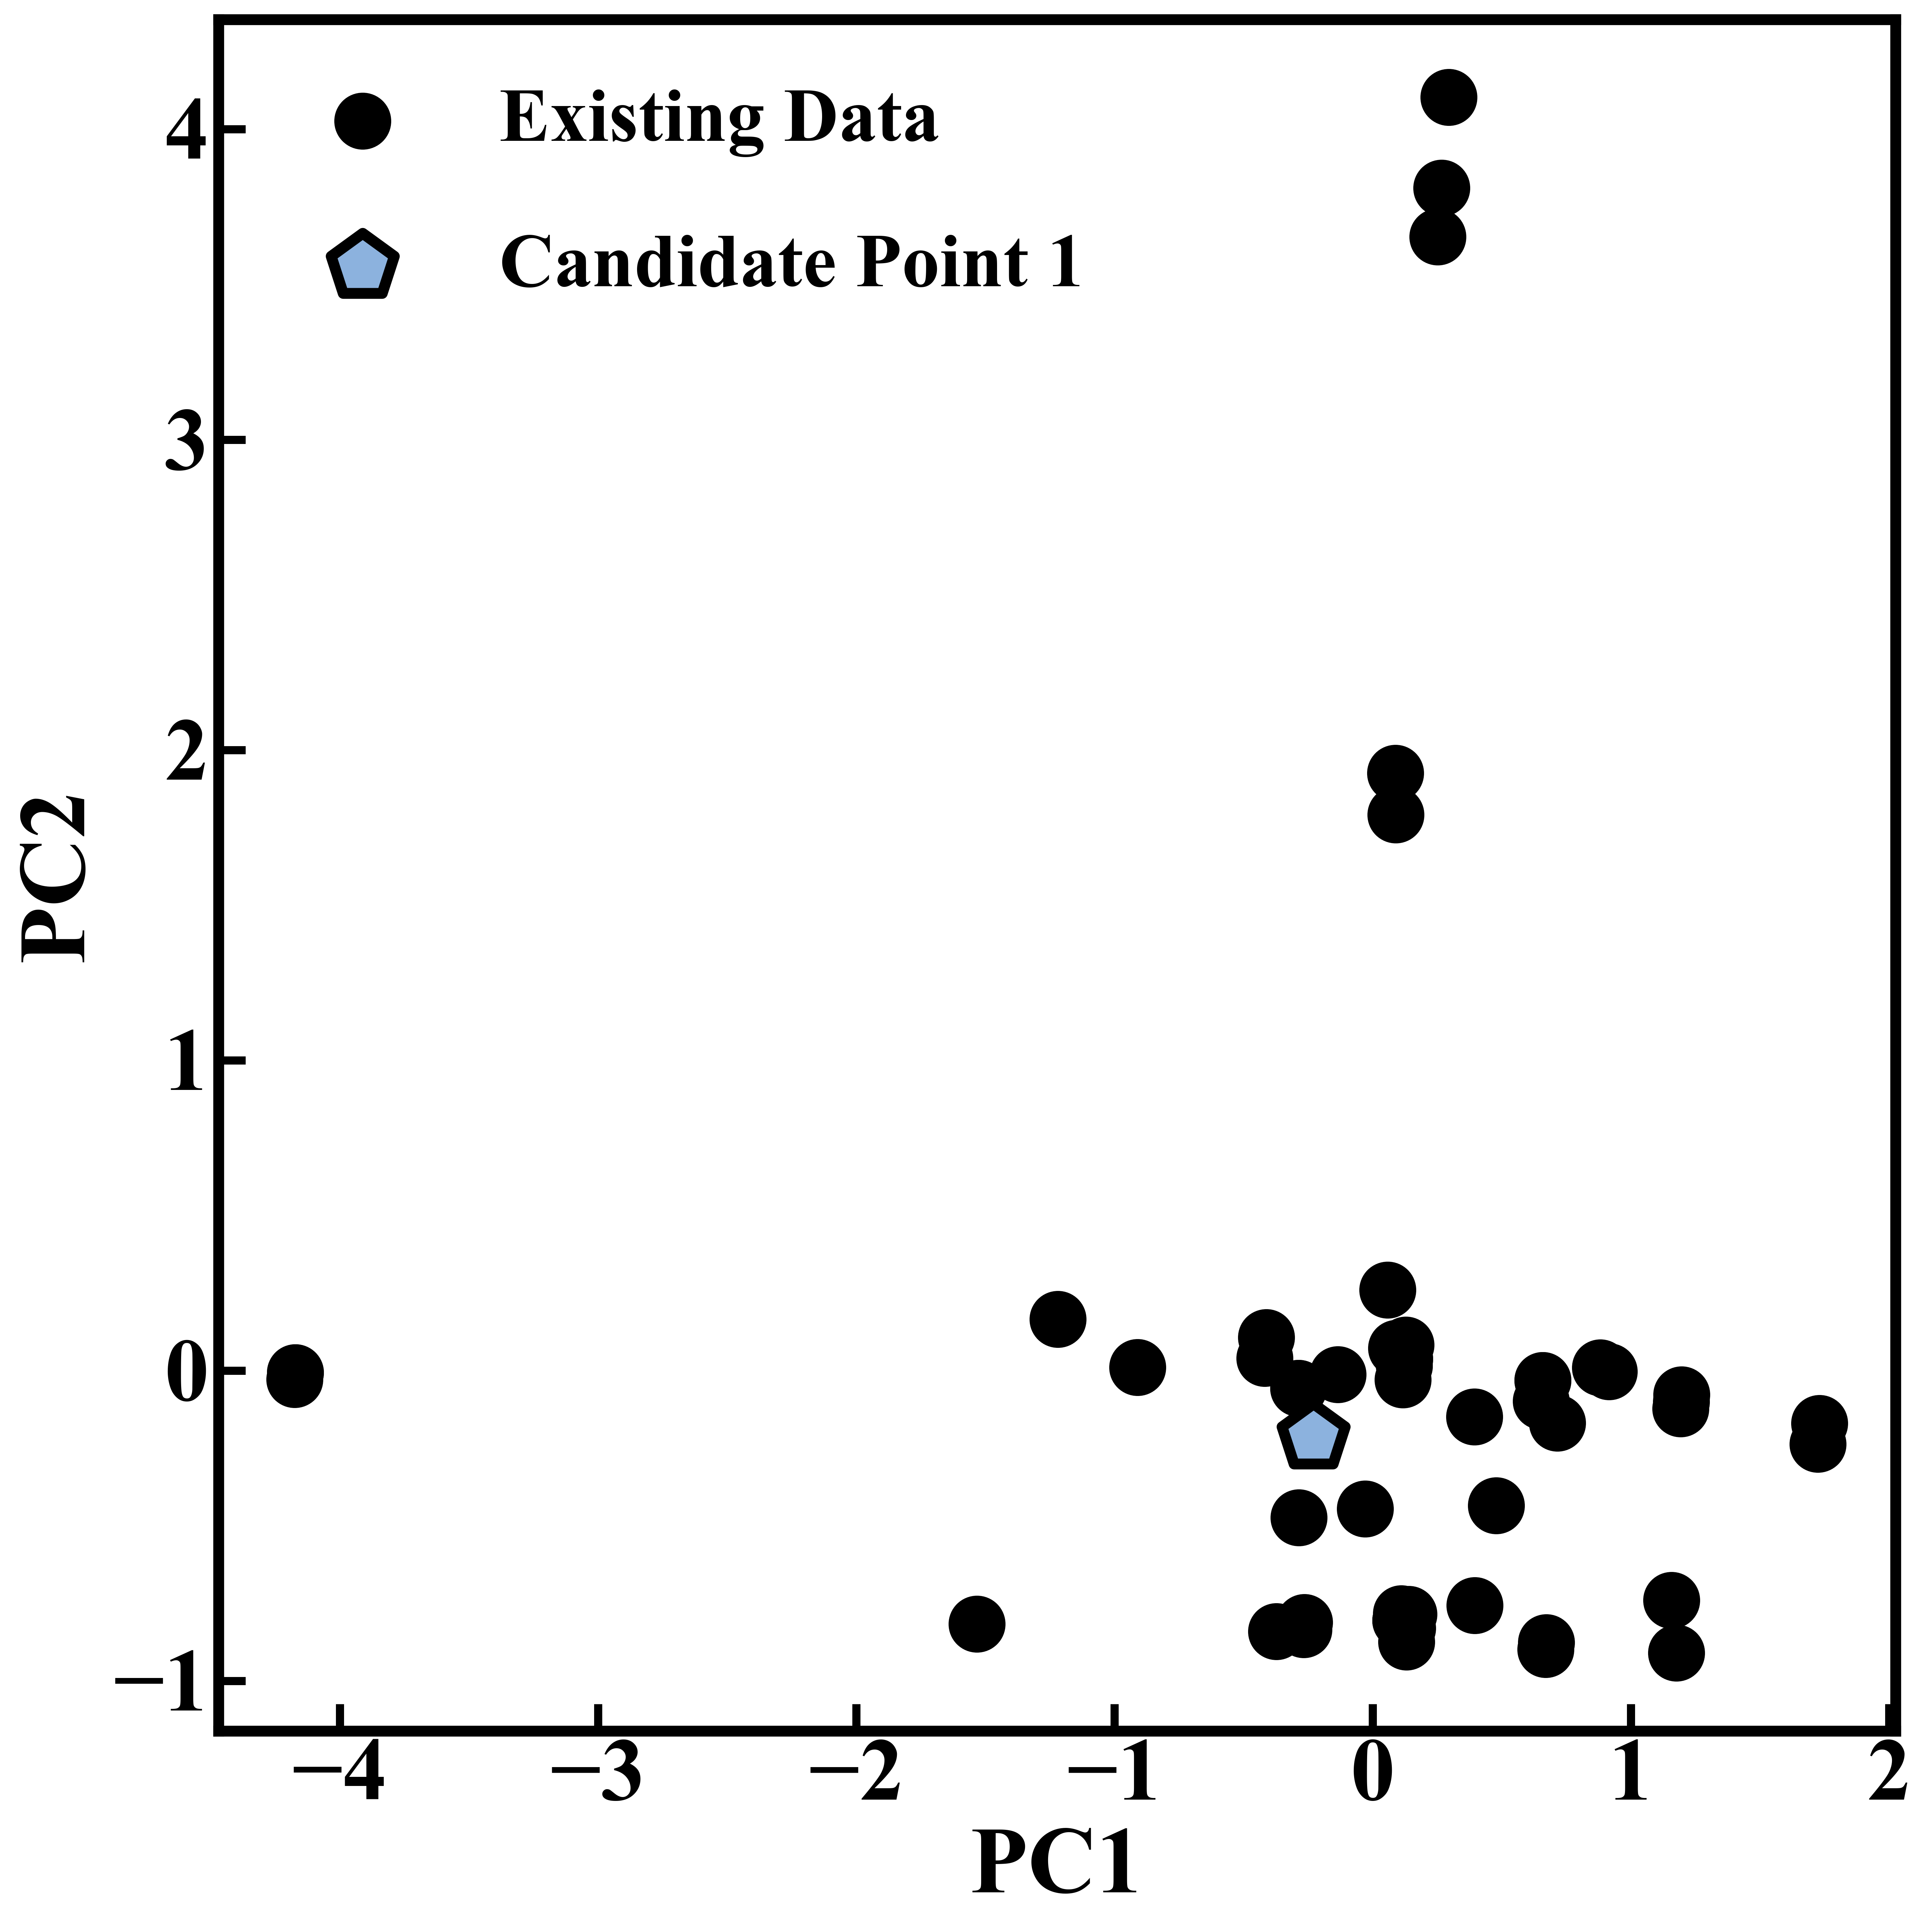

/var/folders/q6/fx9pdmw93d78kwscc37jqndw0000gn/T/ipykernel_36415/1890661105.py:163: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=25, frameon=False)


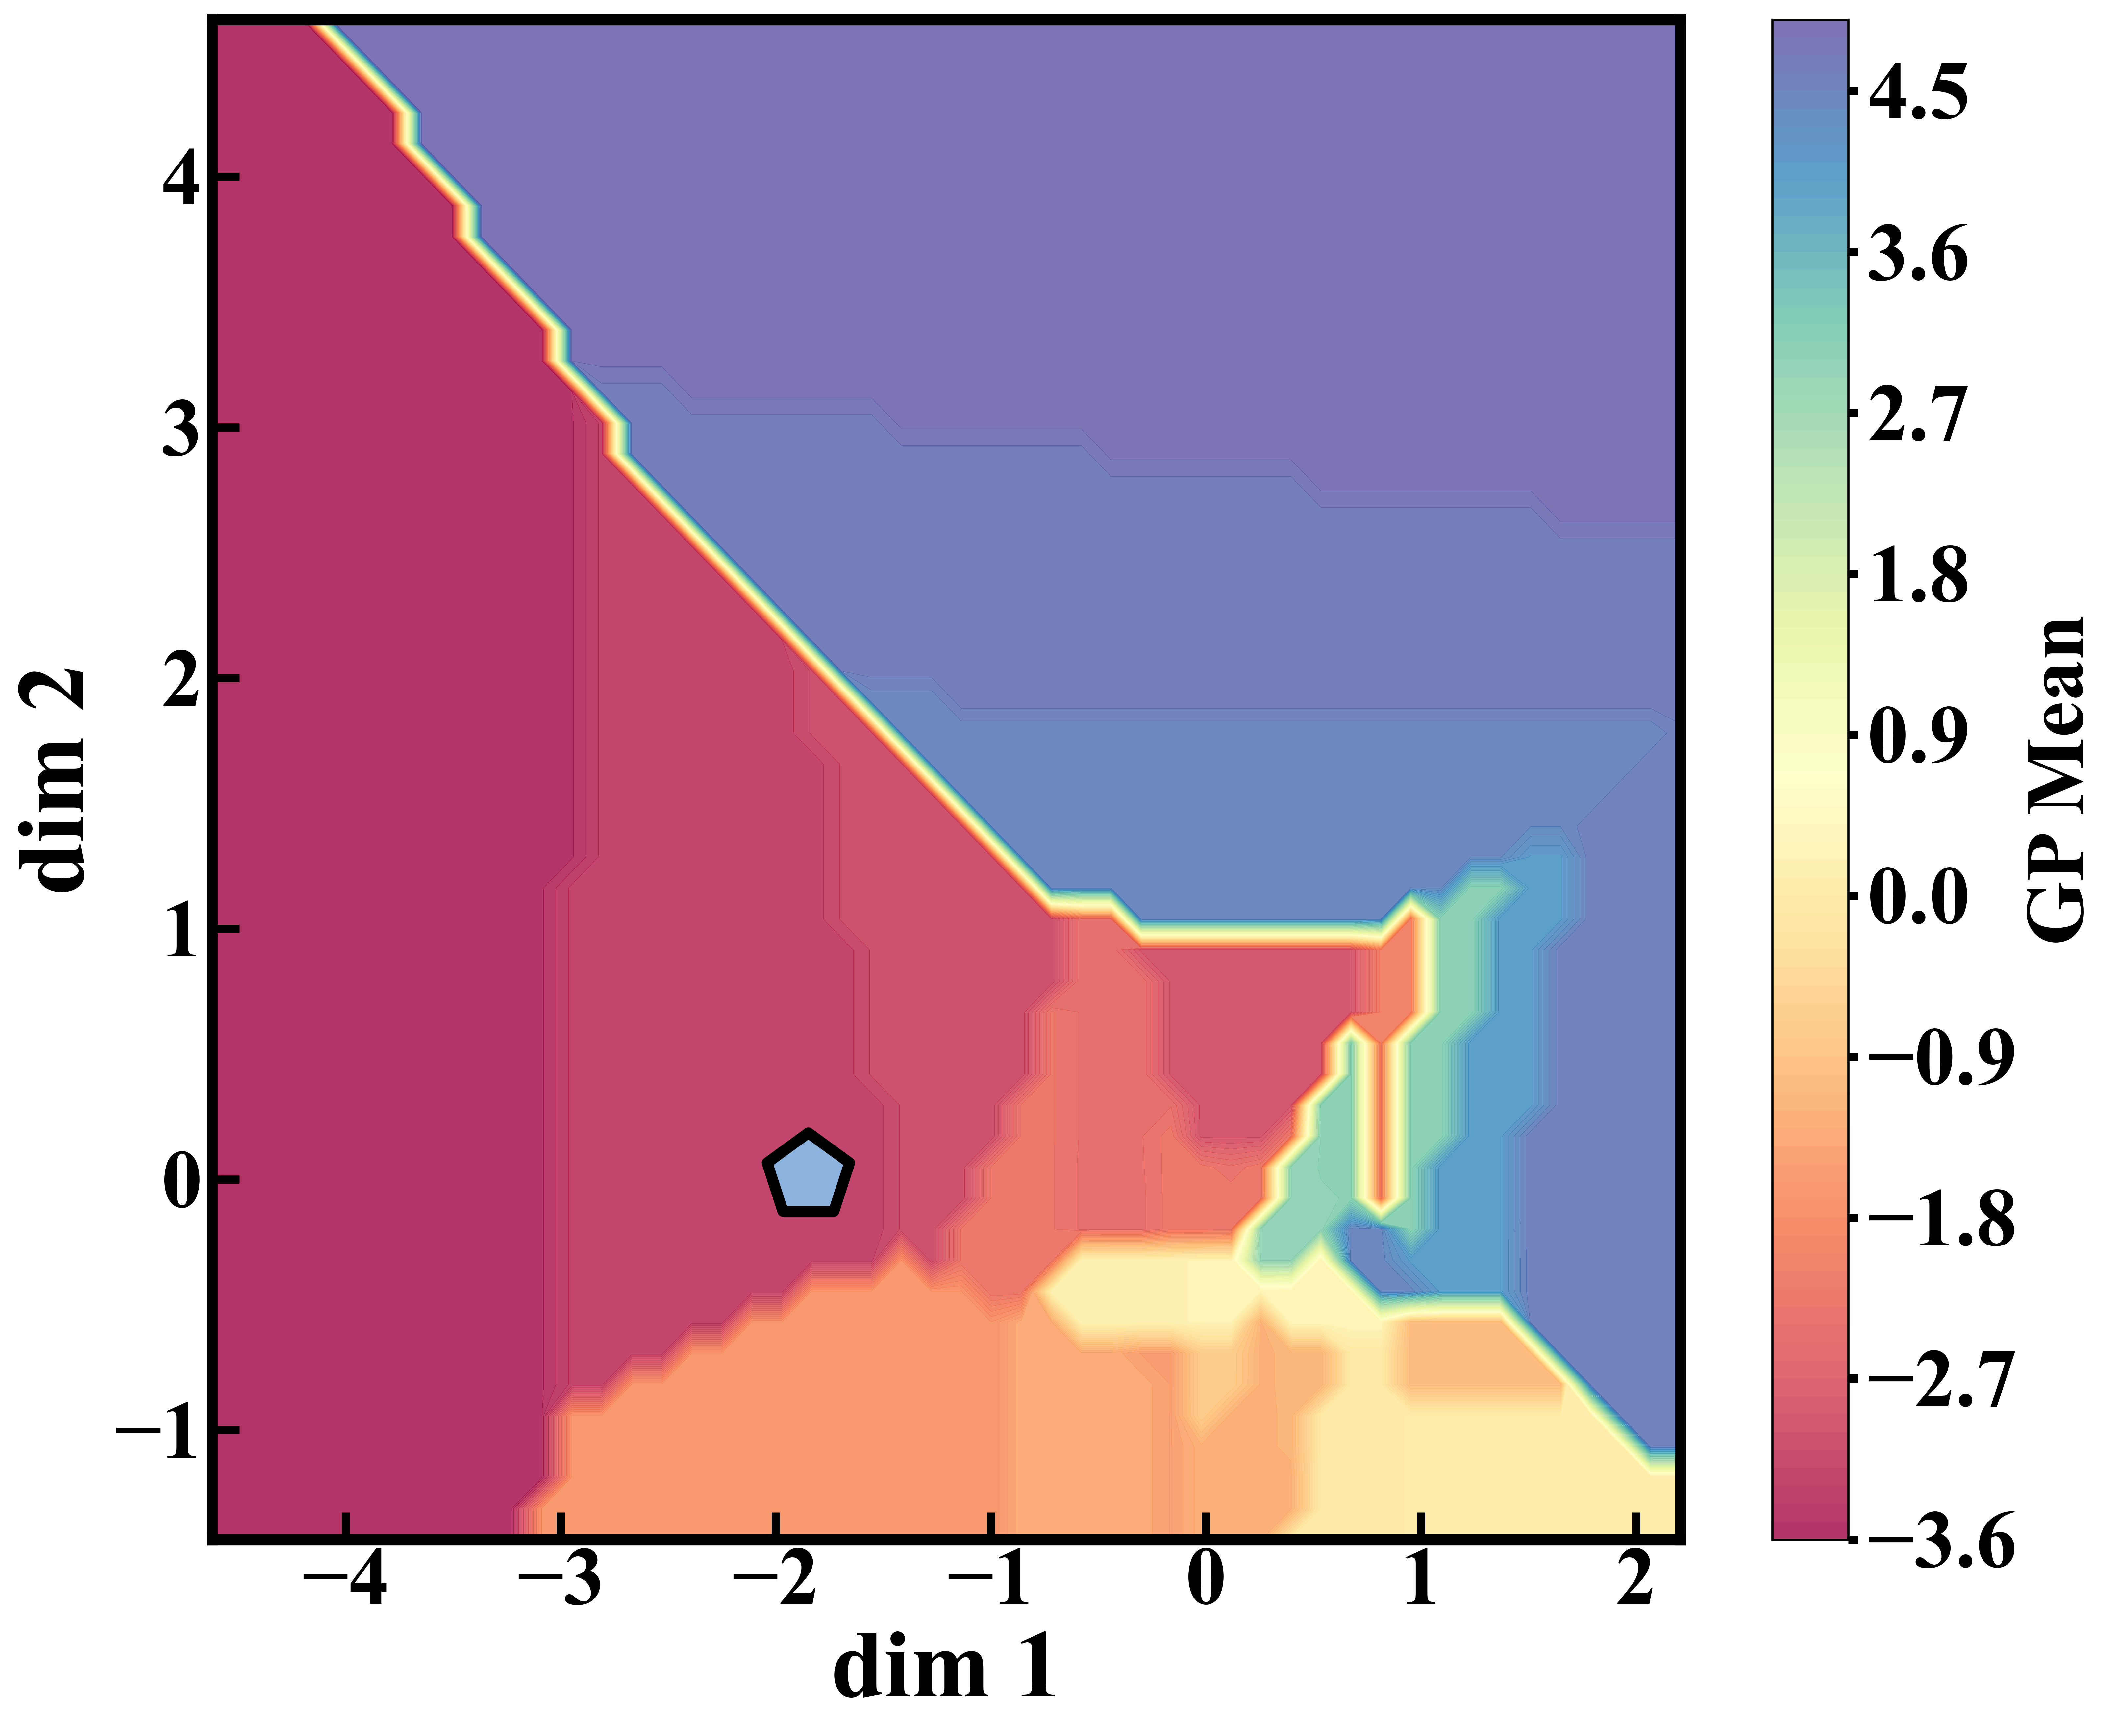

Mean heatmap saved to heatmap_1_mean.png


/var/folders/q6/fx9pdmw93d78kwscc37jqndw0000gn/T/ipykernel_36415/1890661105.py:215: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=25, frameon=False)


Standard deviation heatmap saved to heatmap_1_std.png


<Figure size 640x480 with 0 Axes>

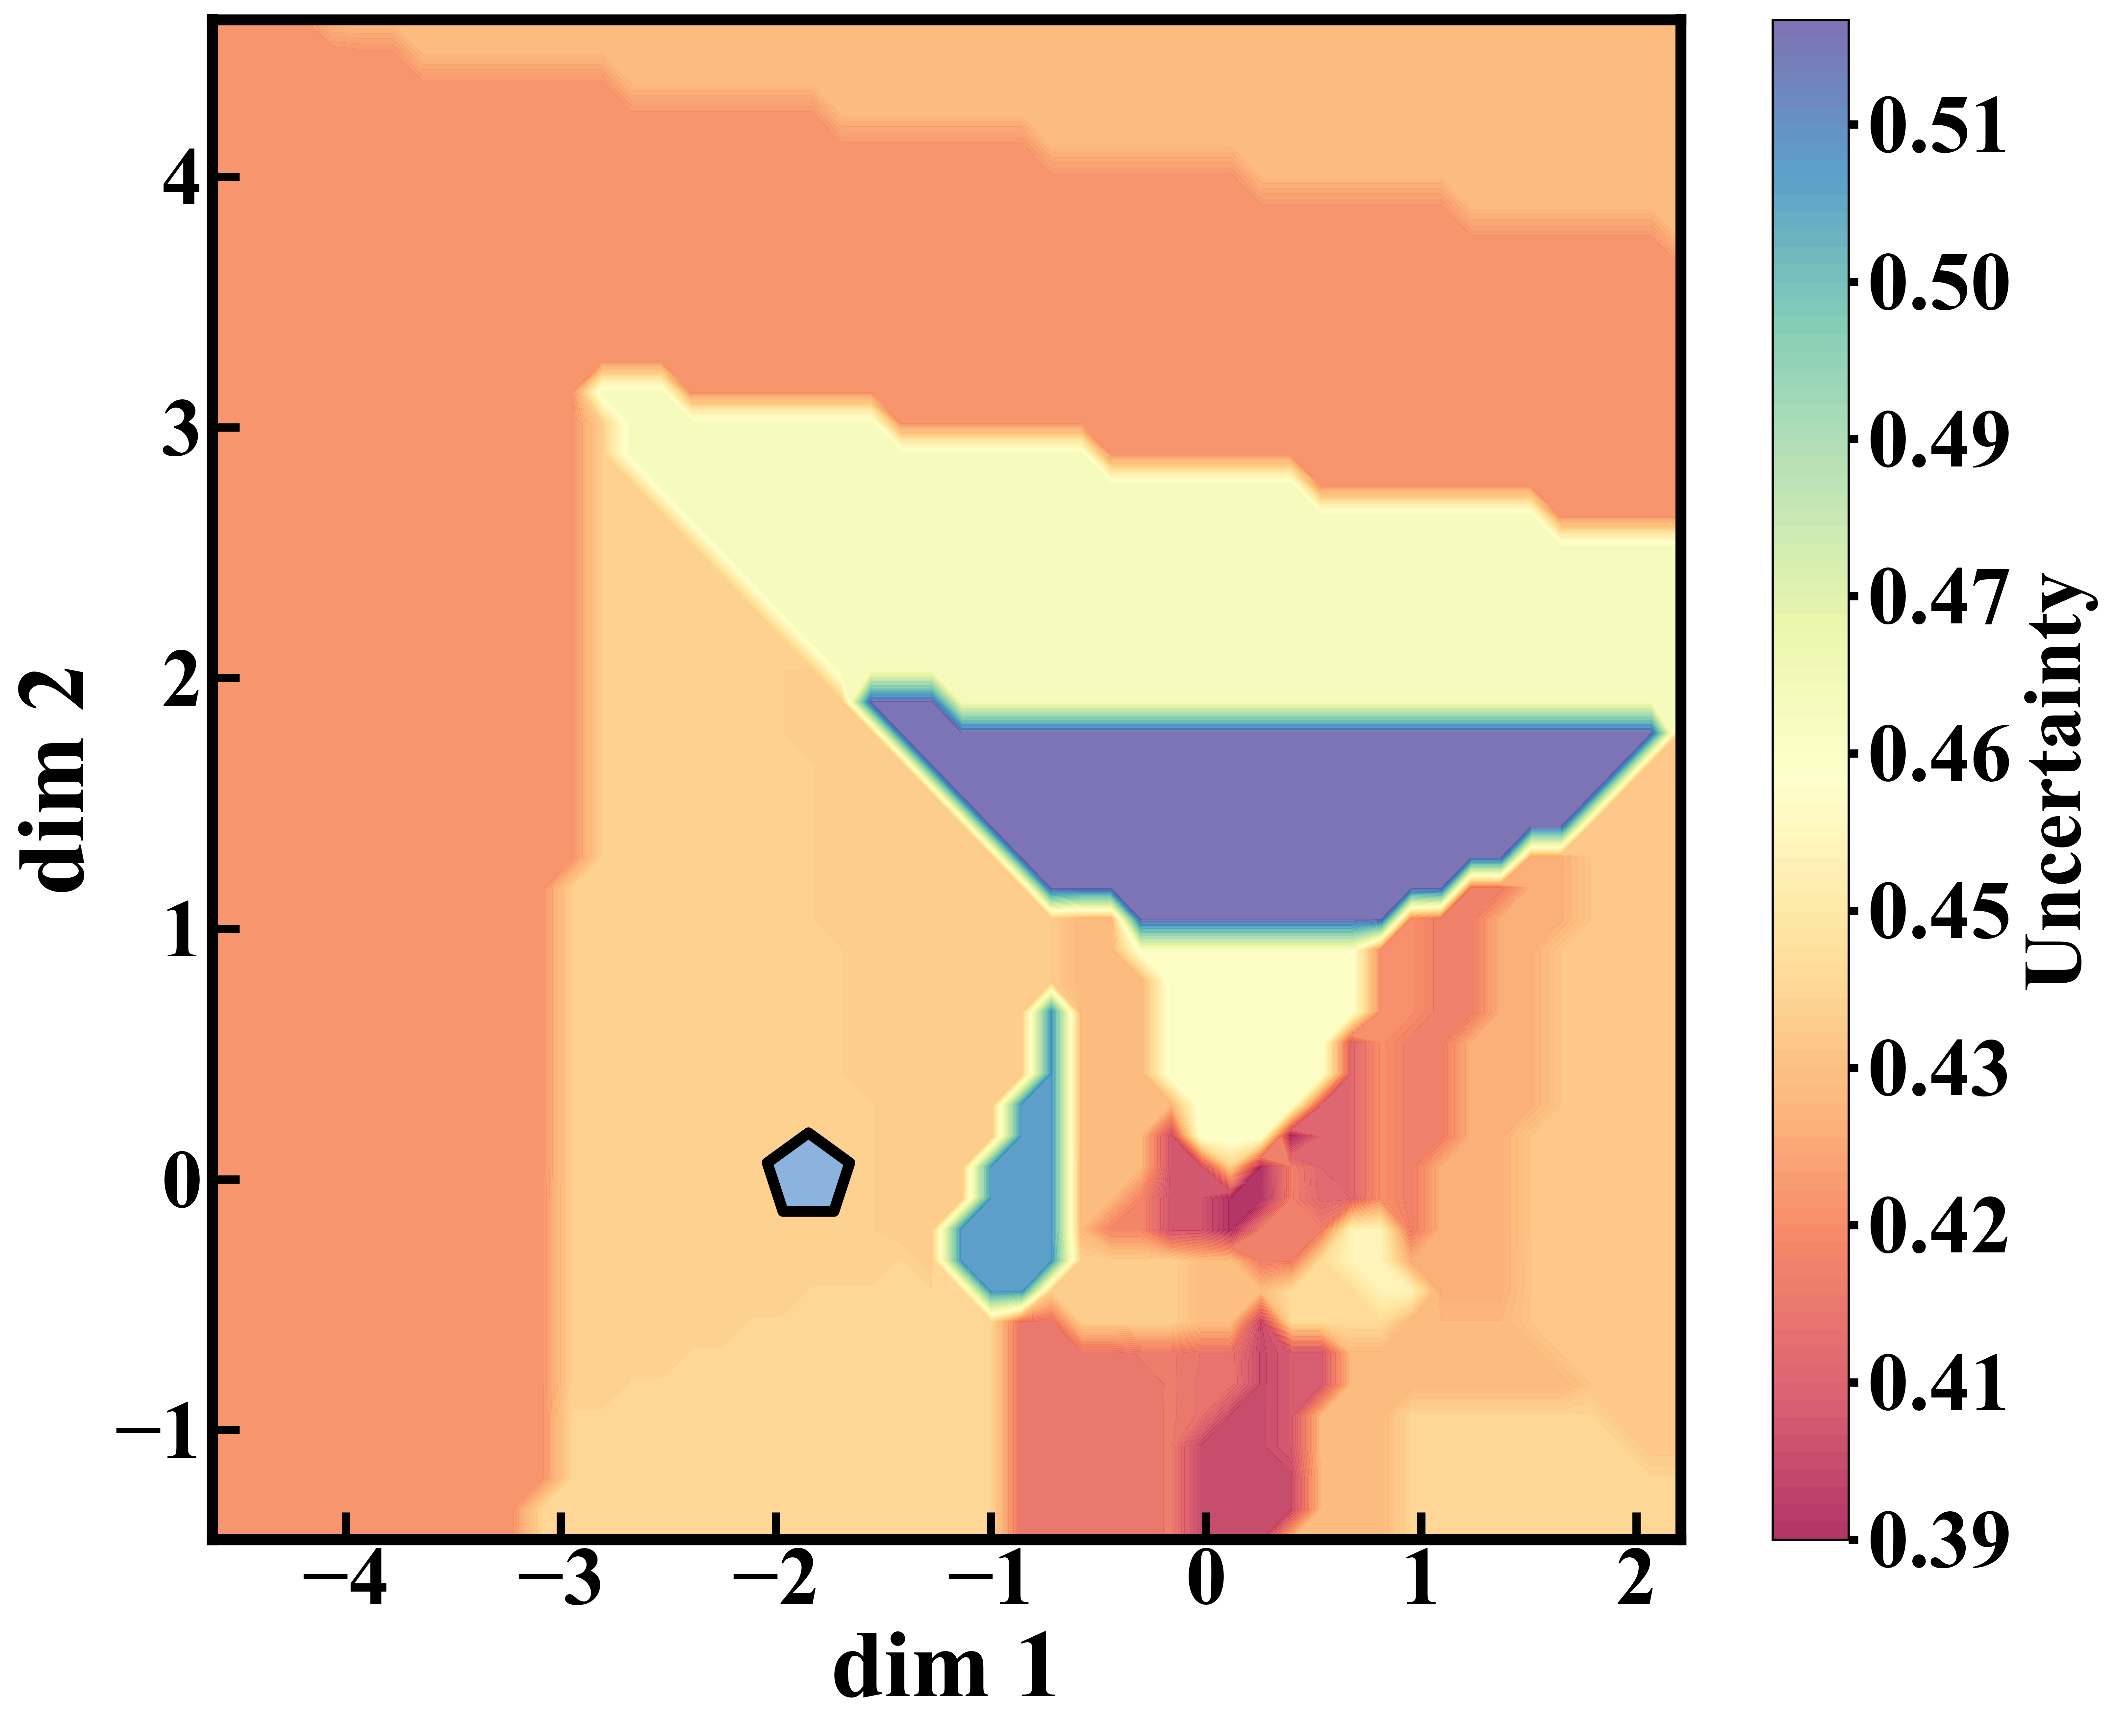


Generating the 2/10th sample:
Recommend #2:
  Material Name: c-Soil(PFOA):biochar
  Weight_ratio: ratio of 1:1
  Initial total mass: 290.0
  Init. Res.(Ω): 2.01
  Init. Pulse Voltage: 150.0
Acquisition Value: -3.521071313335377

=== Visualizations for Recommend #2 ===


<Figure size 640x480 with 0 Axes>

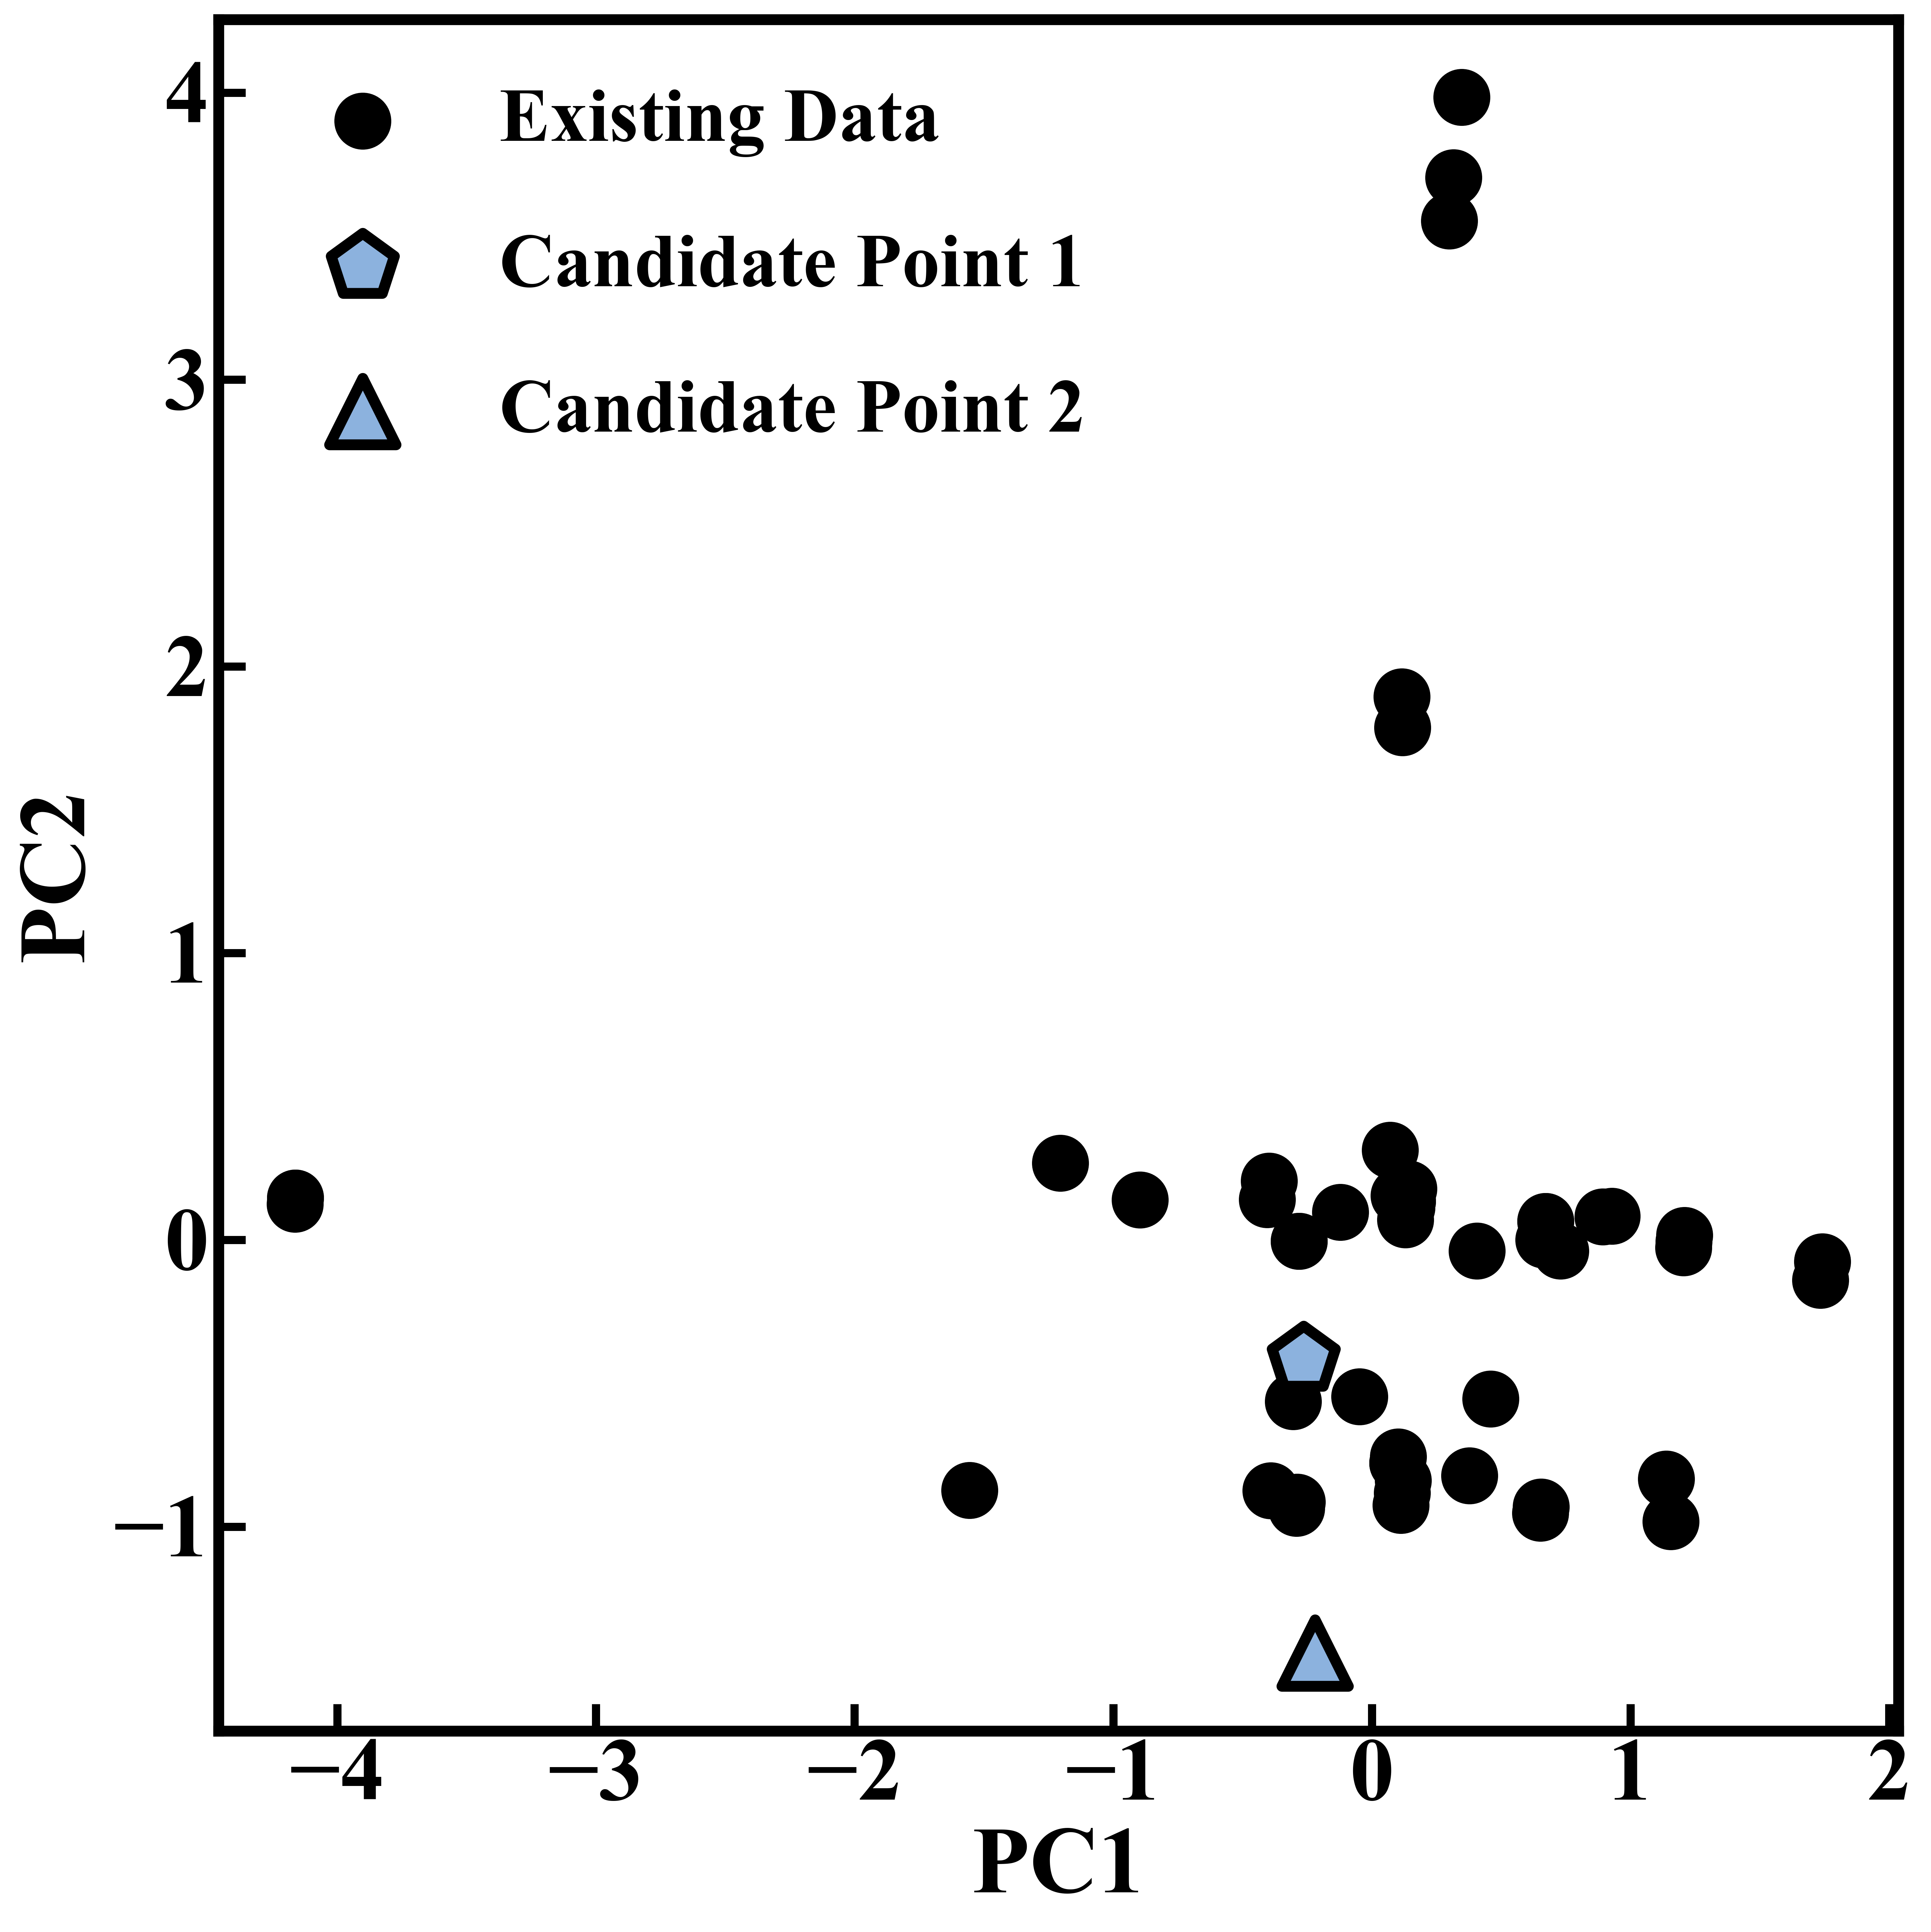

/var/folders/q6/fx9pdmw93d78kwscc37jqndw0000gn/T/ipykernel_36415/1890661105.py:163: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=25, frameon=False)


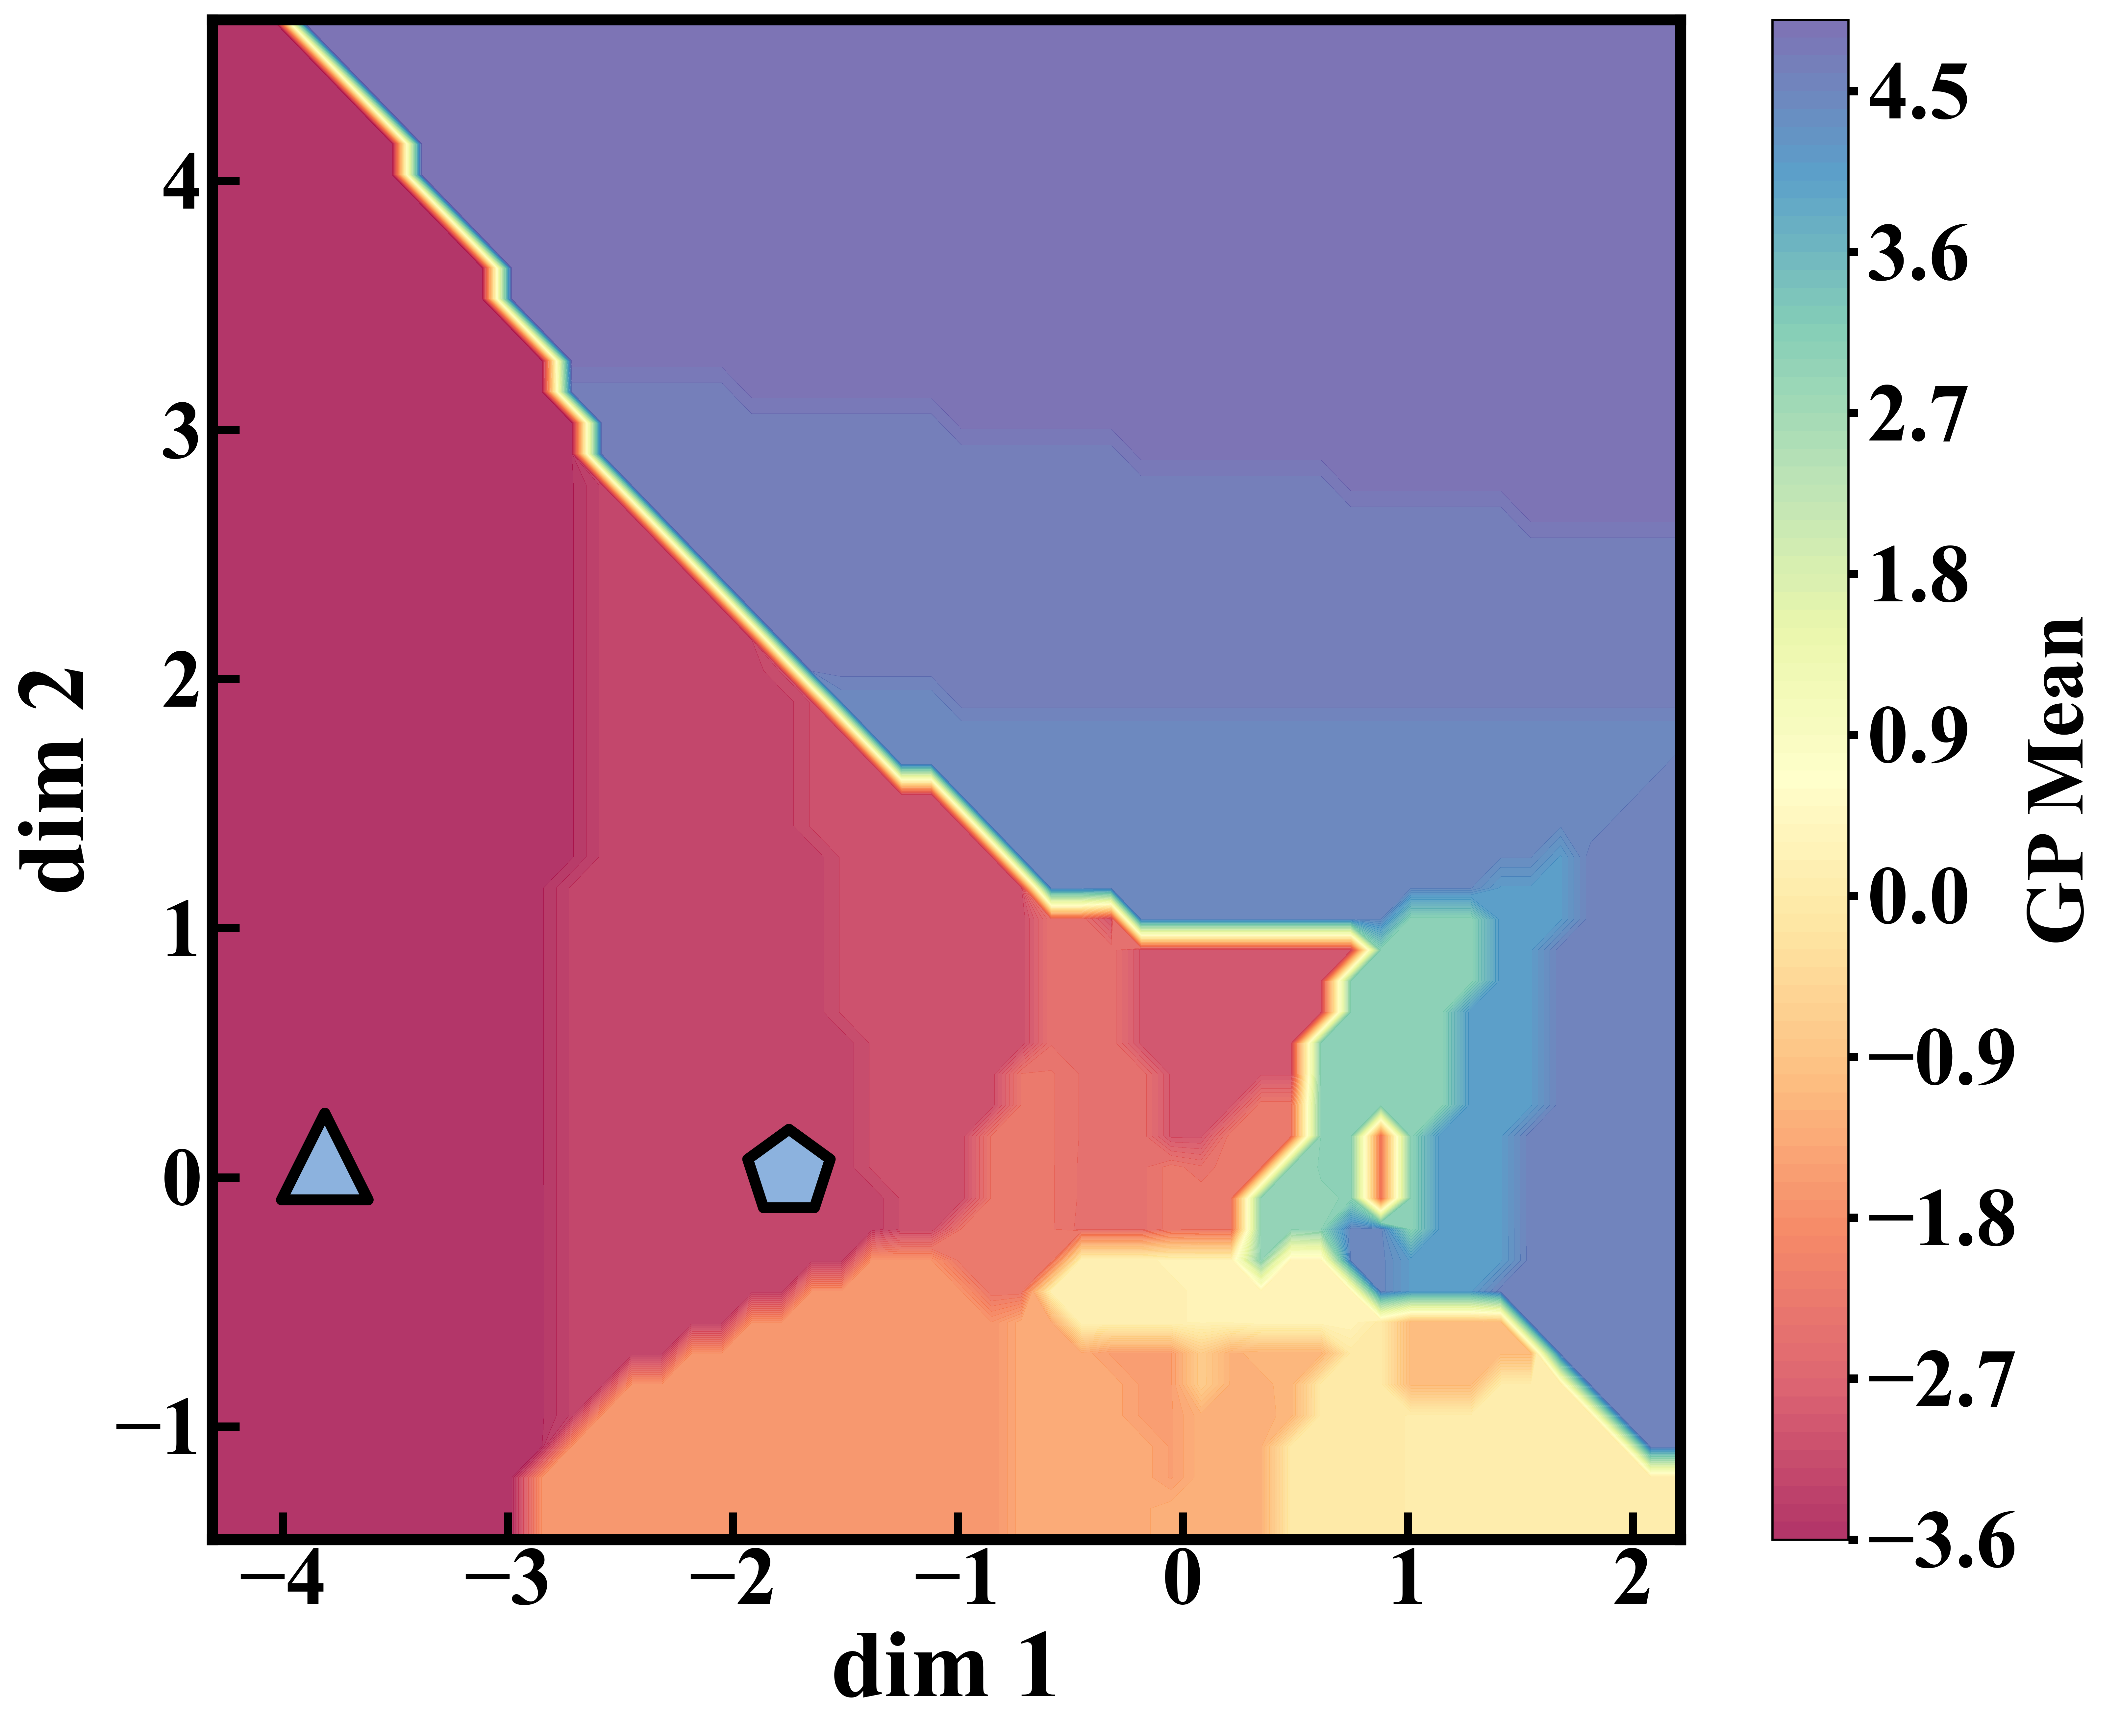

Mean heatmap saved to heatmap_2_mean.png


/var/folders/q6/fx9pdmw93d78kwscc37jqndw0000gn/T/ipykernel_36415/1890661105.py:215: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=25, frameon=False)


Standard deviation heatmap saved to heatmap_2_std.png


<Figure size 640x480 with 0 Axes>

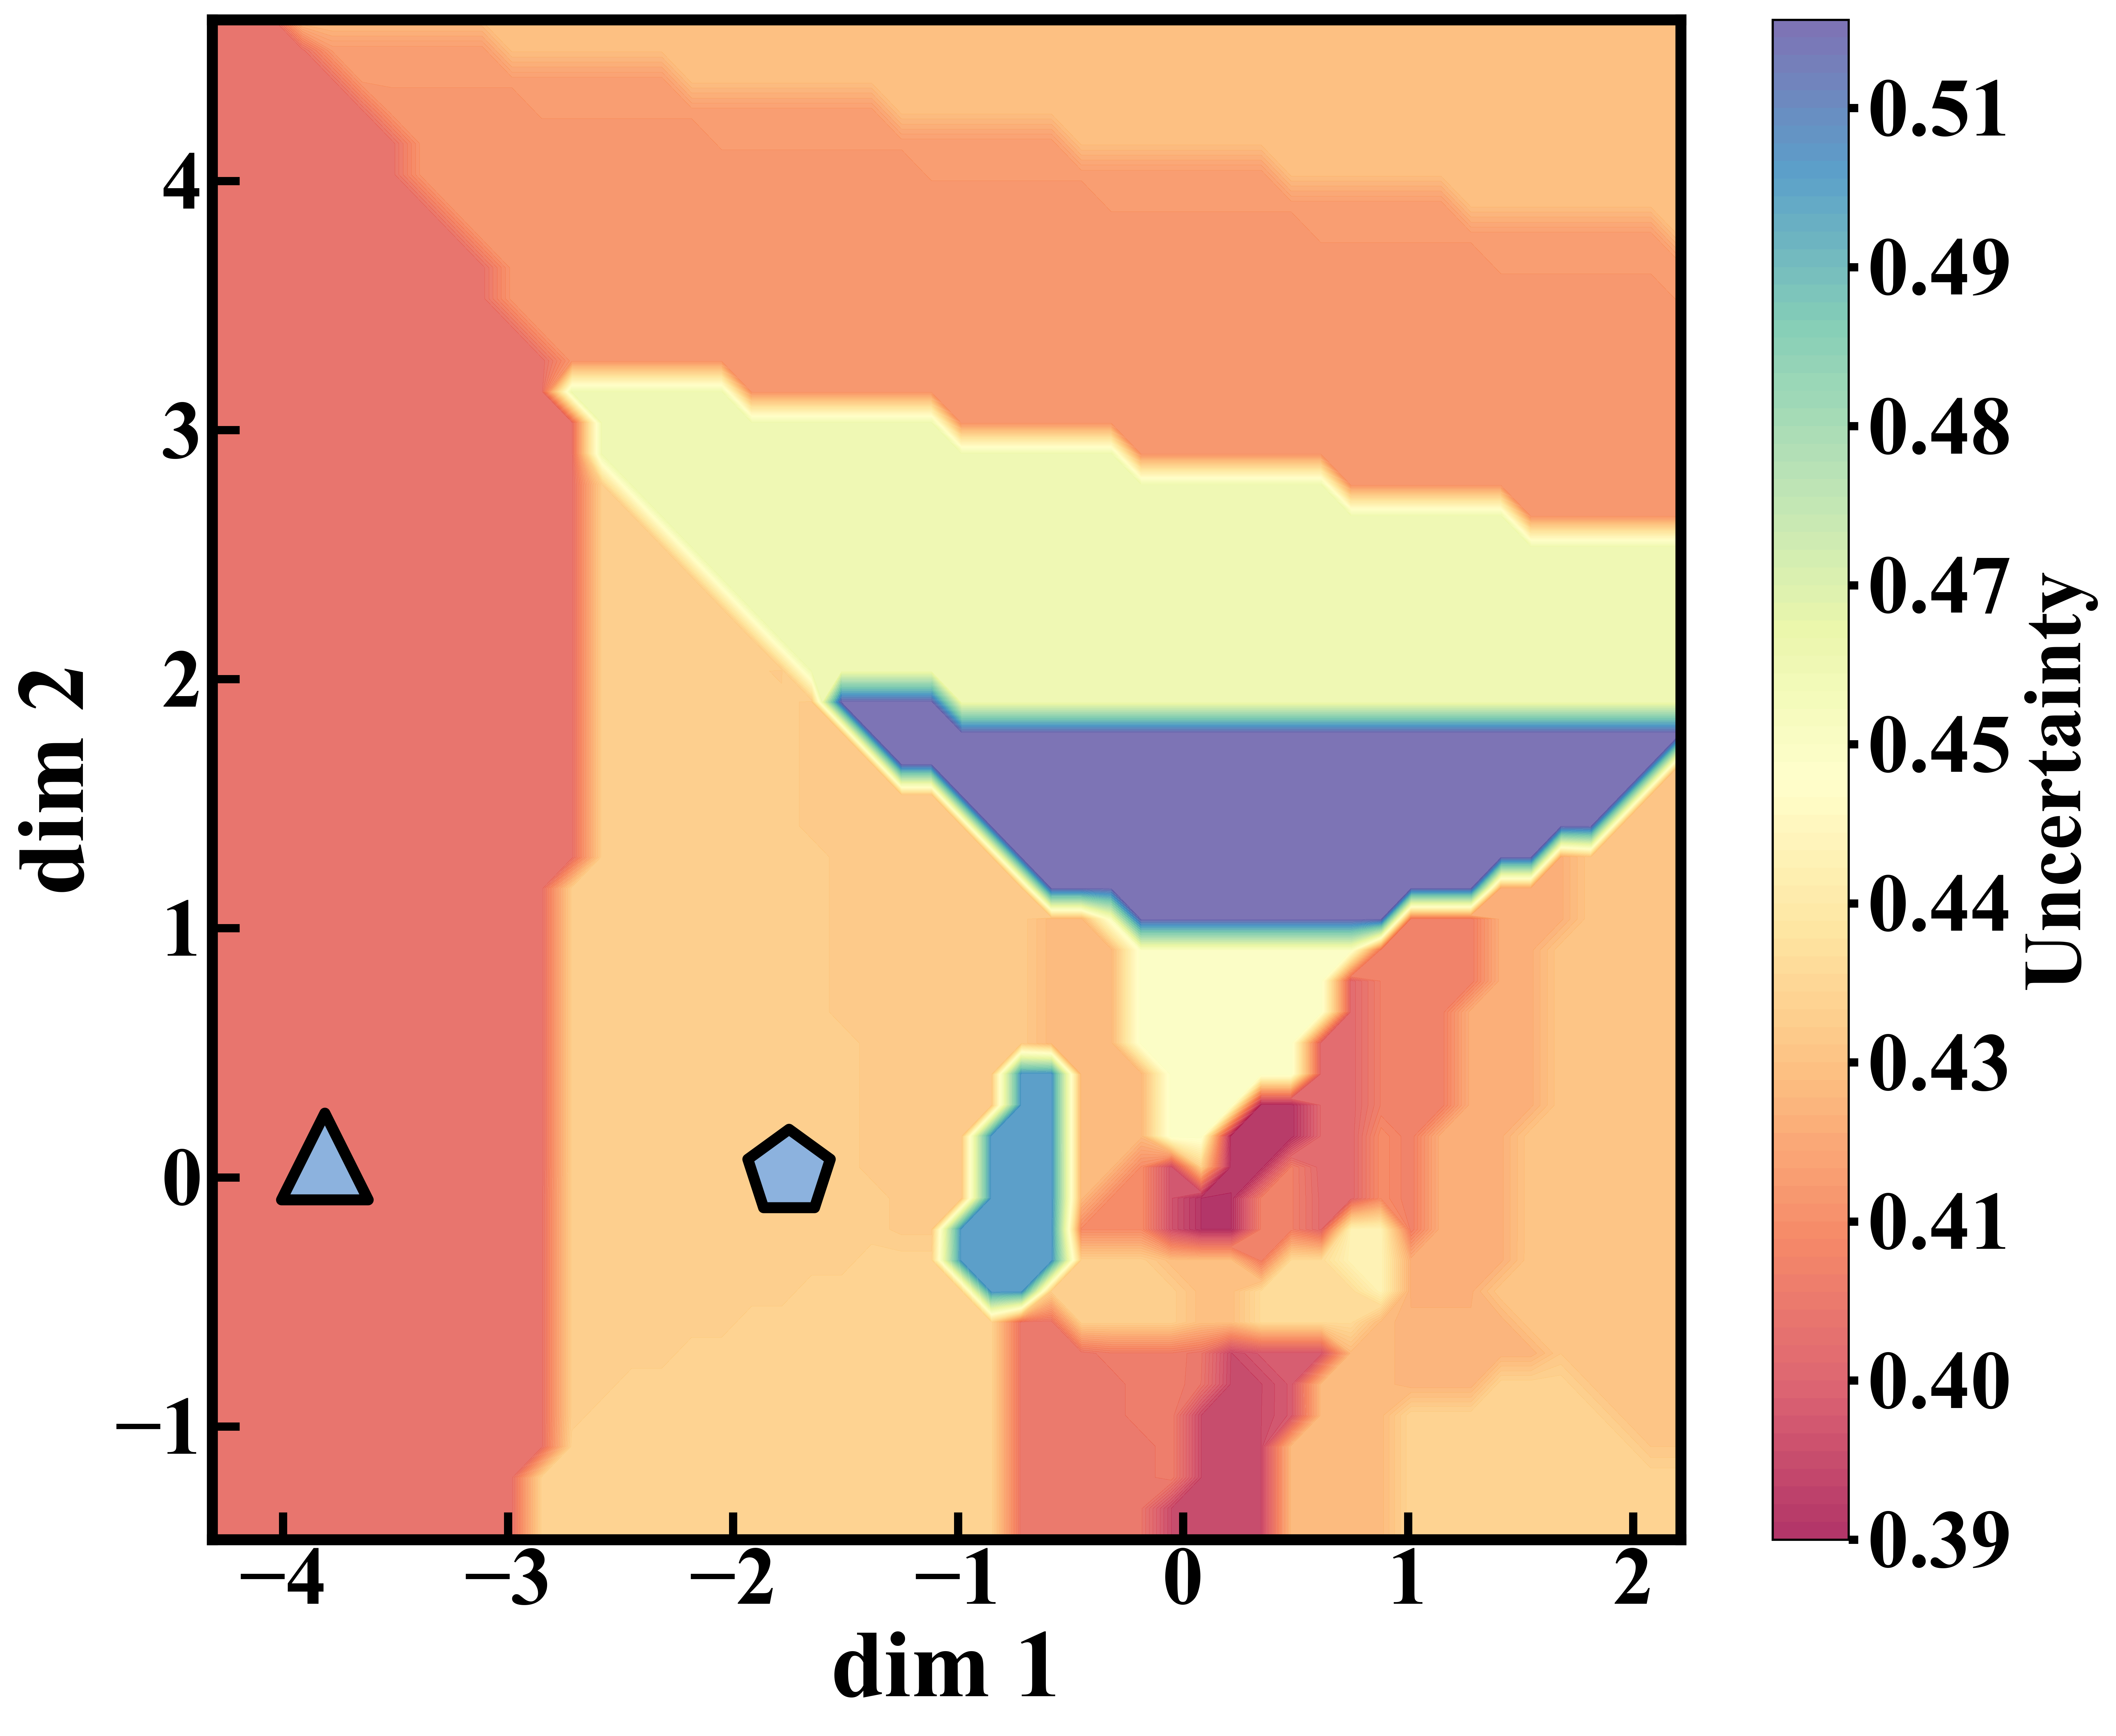


score is 0, batch processing terminated.
Recommend point #1:
   Data: {'Material Name': 'c-Soil(PFOA):biochar', 'Weight_ratio': 'ratio of 1:1', 'Initial total mass': 299.0, 'Init. Res.(Ω)': 1.99, 'Init. Pulse Voltage': 150.0}
   Acquisition Value: -3.205842186991077
Recommend point #2:
   Data: {'Material Name': 'c-Soil(PFOA):biochar', 'Weight_ratio': 'ratio of 1:1', 'Initial total mass': 290.0, 'Init. Res.(Ω)': 2.01, 'Init. Pulse Voltage': 150.0}
   Acquisition Value: -3.521071313335377


<Figure size 640x480 with 0 Axes>

In [47]:
# Recommend experimental points
batch_samples, best_result = recommend_next_expriment(
    gp_P=gp_P,
    existing_data=existing_data, 
    alpha=0.01, 
    gamma=0.5,
    batch_size=10
)

first_sample = batch_samples[0]['sample']
first_acquisition = batch_samples[0]['acquisition']

for i, sample_info in enumerate(batch_samples):
    print(f"Recommend point #{i+1}:")
    print(f"   Data: {sample_info['sample']}")
    print(f"   Acquisition Value: {sample_info['acquisition']}")